In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils.helpers import *
from utils.preprocessing import *
from implementations.least_squares import least_squares
from implementations.ridge_regression import ridge_regression
import datetime
from implementations.costs import compute_loss
%load_ext autoreload
%autoreload 2

In [2]:
y_train, tx_train, ids_train = load_csv_data('data/train.csv')
y_test, tx_test, ids_test = load_csv_data('data/test.csv')

In [1]:
import matplotlib.pyplot as plt


def cross_validation_visualization(lambds, mse_tr, mse_te, save_fig=None):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()
    if save_fig != None:
        plt.savefig(save_fig)

In [4]:
x_train_sep, y_train_sep, ids_train_sep, indx_train_sep = split_data_by_DER_mass_MMC(tx_train, y_train, ids_train)
x_test_sep, y_test_sep, ids_test_sep, indx_test_sep = split_data_by_DER_mass_MMC(tx_test, y_test, ids_test)

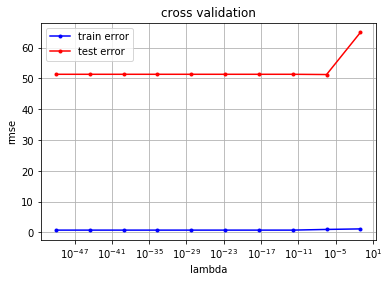

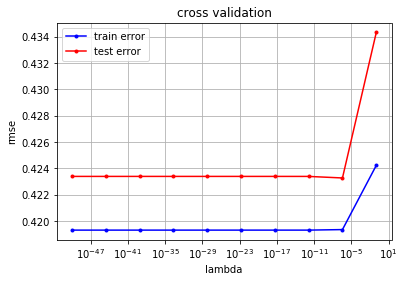

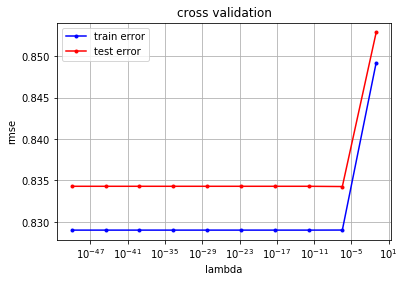

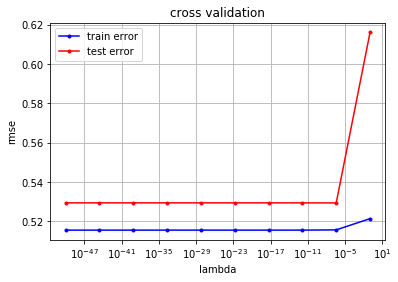

KeyboardInterrupt: 

In [22]:
number_of_models = 8

best_lambdas = []
for i in range(number_of_models):
    x_tr = x_train_sep[i]
    y_tr = y_train_sep[i]
    lambdas = np.logspace(-50, -1, 10)
#     acc_tr = []
#     acc_te = []
    rmse_tr = []
    rmse_te = [] 
    for t, lambda_ in enumerate(lambdas):
#         correct_test = 0
#         correct_train = 0
        tmp = 0
        rmse_tr_t = []
        rmse_te_t = []
        for train_ind, test_ind in k_fold_split(y=y_tr, x=x_tr, n_splits=10):
            x_train_kfold = x_tr[train_ind]
            y_train_kfold = y_tr[train_ind]
            x_test_kfold = x_tr[test_ind]
            y_test_kfold = y_tr[test_ind]
            tmp = len(y_train_kfold)
            #new_y_te = np.ones(len(y_test_kfold))
            #x_tr_std, x_te_std = min_max_normalization(x_train_kfold, x_test_kfold)
            x_tr_std = build_poly(x_train_kfold, 3)
            x_te_std = build_poly(x_test_kfold, 3)
            w = ridge_regression(tx=x_tr_std, y=y_train_kfold, lamb=lambda_)
            loss_tr = np.sqrt(2*compute_loss(y_train_kfold, x_tr_std, w))
            loss_te = np.sqrt(2*compute_loss(y_test_kfold, x_te_std, w))
            rmse_tr_t.append(loss_tr)
            rmse_te_t.append(loss_te)
#             predictions_train = compute(w, x_tr_std)
#             predictions_test = predict_labels(w, x_te_std)
#             correct_test += np.sum(predictions_test==y_test_kfold)
#             correct_train += np.sum(predictions_train==y_train_kfold)
#         acc_te.append(correct_test*1.0/len(y_tr))
#         acc_tr.append(correct_train*1.0/(10*tmp))
        rmse_tr.append(np.mean(rmse_tr_t))
        rmse_te.append(np.mean(rmse_te_t))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    #best_lambdas.append(lambdas[np.argmax(rmse_te)])

In [40]:
for i in range(8):
    x_tr_std, x_te_std = min_max_normalization(x_train_sep[i], x_test_sep[i])
    w[i] = ridge_regression(tx=x_tr_std, y=y_train_sep[i], lamb=best_lambdas[i])
w

{0: array([ 2.34553063e+00, -3.25528448e+00, -9.72898610e+00,  2.26585375e+00,
         3.47956148e+00,  3.11539327e+00,  3.77878048e+03, -1.64887967e+00,
        -5.68911150e-02, -2.50159513e+03,  8.90913783e-03, -1.85045955e-03,
        -1.75303612e+03,  1.18334603e-02,  5.46147441e-04, -4.95729531e+00,
        -3.04702198e-02,  4.01158651e-01]),
 1: array([ 2.50590937e+00, -2.53475486e+00,  5.26041487e+03,  7.24600756e-01,
        -5.26058100e+03,  3.79219085e+03, -6.85973683e-01,  8.51173761e-02,
        -1.94317845e+03, -2.05800440e-03, -6.14620434e-03, -1.84620228e+03,
         1.44486282e-02,  4.32218251e-03,  1.01232331e+00,  2.48969837e-03,
        -3.99567407e-01]),
 2: array([ 1.13867029e+00, -2.58808846e+00, -7.04472204e+00,  3.60123134e-01,
         2.05888359e+00,  3.45114500e-01,  7.17909666e+02, -3.95556846e+00,
         2.91820856e-01, -3.02108768e+02,  9.61894366e-03, -2.33992111e-02,
        -2.47768346e+02, -3.38250192e-02,  2.08871080e-03,  5.68500812e-01,
        

In [41]:
for i in range(8):
    x_tr_std, x_te_std = min_max_normalization(x_train_sep[i], x_test_sep[i])
    predictions = predict_labels(w[i], x_te_std)
    y_test[indx_test_sep[i]] = predictions

In [42]:
create_csv_submission(ids_test, y_test, "output5.csv")

In [9]:
accuracy = []
for train_ind, test_ind in k_fold_split(y=y_train, x=tx_train, n_splits=10):
    x_tr = tx_train[train_ind]
    y_tr = y_train[train_ind]
    x_te = tx_train[test_ind]
    y_te = y_train[test_ind]
    
    new_y_te = np.ones(len(y_te))
    
    ids_tr = ids_train[train_ind]
    ids_te = ids_test[test_ind]
    
    x_train_sep, y_train_sep, ids_train_sep, indx_train_sep = split_data_by_DER_mass_MMC(x_tr, y_tr, ids_tr)
    x_test_sep, y_test_sep, ids_test_sep, indx_test_sep = split_data_by_DER_mass_MMC(x_te, y_te, ids_te)
    
    w = {}
    correct = 0
    for i in range(8):
        x_tr_std, x_te_std = min_max_normalization(x_train_sep[i], x_test_sep[i])
        w[i] = ridge_regression(tx=x_tr_std, y=y_train_sep[i], lamb=best_lambdas[i])
        predictions = predict_labels(w[i], x_te_std)
        new_y_te[indx_test_sep[i]] = predictions
        #correct+= np.sum(predictions==y_test_sep[i])
    #accuracy.append(correct*1.0/len(y_te))
    accuracy.append(np.sum(new_y_te == y_te)*1.0/len(y_te))
print (np.mean(accuracy))

0.694824


In [9]:
np.mean(accuracy)

0.7648360000000001

In [15]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for column in range(x.shape[1]):
        for deg in range(1, degree+1):
            poly = np.c_[poly, np.power(x[:, column], deg)]
    return poly

In [16]:
tx_train.shape

(250000, 30)

In [17]:
a = build_poly(tx_train, 3)
a.shape

(250000, 91)